In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
import yaml
from crewai import Agent, Task, Crew,LLM
ollama_llm = LLM(
            model="ollama/llama3.2:latest",
            api_base="http://localhost:11434"
            )

### loading tasks and agent yaml files

In [3]:
# Define file paths for YAML configurations
files = {
    'agents': 'config/agents.yaml',
    'tasks': 'config/tasks.yaml'
}

# Load configurations from YAML files
configs = {}
for config_type, file_path in files.items():
    with open(file_path, 'r') as file:
        configs[config_type] = yaml.safe_load(file)

# Assign loaded configurations to specific variables
agents_config = configs['agents']
tasks_config = configs['tasks']

### Creating custom tools

In [4]:
import os
import json
from crewai.tools import BaseTool
import requests

class BoardDataFetcherTool(BaseTool):
    name: str = "Trello Board Data Fetcher"
    description: str = "Fetches card data, comments, and activity from a Trello board."

    api_key: str = os.environ['TRELLO_API_KEY']
    api_token: str = os.environ['TRELLO_API_TOKEN']
    board_id: str = os.environ['TRELLO_BOARD_ID']

    def _run(self) -> dict:
        """
        Fetch all cards from the specified Trello board.
        """
        url = f"{os.getenv('DLAI_TRELLO_BASE_URL', 'https://api.trello.com')}/1/boards/{self.board_id}/cards"

        query = {
            'key': self.api_key,
            'token': self.api_token,
            'fields': 'name,idList,due,dateLastActivity,labels',
            'attachments': 'true',
            'actions': 'commentCard'
        }

        response = requests.get(url, params=query)
        print("Getting data from Trello board ")

        print("Here is the board data : ",response.json())
        print("#############")

        
        if response.status_code == 200:
            return response.json()
        else:
            # Fallback in case of timeouts or other issues
            #return json.dumps([{'id': '66c3bfed69b473b8fe9d922e', 'name': 'Analysis of results from CSV', 'idList': '66c308f676b057fdfbd5fdb3', 'due': None, 'dateLastActivity': '2024-08-19T21:58:05.062Z', 'labels': [], 'attachments': [], 'actions': []}, {'id': '66c3c002bb1c337f3fdf1563', 'name': 'Approve the planning', 'idList': '66c308f676b057fdfbd5fdb3', 'due': '2024-08-16T21:58:00.000Z', 'dateLastActivity': '2024-08-19T21:58:57.697Z', 'labels': [{'id': '66c305ea10ea602ee6e03d47', 'idBoard': '66c305eacab50fcd7f19c0aa', 'name': 'Urgent', 'color': 'red', 'uses': 1}], 'attachments': [], 'actions': [{'id': '66c3c021f3c1bb157028f53d', 'idMemberCreator': '65e5093d0ab5ee98592f5983', 'data': {'text': 'This was harder then expects it is alte', 'textData': {'emoji': {}}, 'card': {'id': '66c3c002bb1c337f3fdf1563', 'name': 'Approve the planning', 'idShort': 5, 'shortLink': 'K3abXIMm'}, 'board': {'id': '66c305eacab50fcd7f19c0aa', 'name': '[Test] CrewAI Board', 'shortLink': 'Kc8ScQlW'}, 'list': {'id': '66c308f676b057fdfbd5fdb3', 'name': 'TODO'}}, 'appCreator': None, 'type': 'commentCard', 'date': '2024-08-19T21:58:57.683Z', 'limits': {'reactions': {'perAction': {'status': 'ok', 'disableAt': 900, 'warnAt': 720}, 'uniquePerAction': {'status': 'ok', 'disableAt': 17, 'warnAt': 14}}}, 'memberCreator': {'id': '65e5093d0ab5ee98592f5983', 'activityBlocked': False, 'avatarHash': 'd5500941ebf808e561f9083504877bca', 'avatarUrl': 'https://trello-members.s3.amazonaws.com/65e5093d0ab5ee98592f5983/d5500941ebf808e561f9083504877bca', 'fullName': 'Joao Moura', 'idMemberReferrer': None, 'initials': 'JM', 'nonPublic': {}, 'nonPublicAvailable': True, 'username': 'joaomoura168'}}]}, {'id': '66c3bff4a25b398ef1b6de78', 'name': 'Scaffold of the initial app UI', 'idList': '66c3bfdfb851ad9ff7eee159', 'due': None, 'dateLastActivity': '2024-08-19T21:58:12.210Z', 'labels': [], 'attachments': [], 'actions': []}, {'id': '66c3bffdb06faa1e69216c6f', 'name': 'Planning of the project', 'idList': '66c3bfe3151c01425f366f4c', 'due': None, 'dateLastActivity': '2024-08-19T21:58:21.081Z', 'labels': [], 'attachments': [], 'actions': []}])
            return "unable to fect the data"


In [5]:
class CardDataFetcherTool(BaseTool):
  name: str = "Trello Card Data Fetcher"
  description: str = "Fetches card data from a Trello board."

  api_key: str = os.environ['TRELLO_API_KEY']
  api_token: str = os.environ['TRELLO_API_TOKEN']
  

  def _run(self, card_id: str) -> dict:
    print("Card id ", card_id)
    
    url = f"{os.getenv('DLAI_TRELLO_BASE_URL', 'https://api.trello.com')}/1/cards/{card_id}"
    query = {
      'key': self.api_key,
      'token': self.api_token
    }
    response = requests.get(url, params=query)
    print("Getting data from Trello Cards ")

    print("Here is the card data : ",response.json())
    print("#############")

    if response.status_code == 200:
      return response.json()
    else:
      # Fallback in case of timeouts or other issues
      return json.dumps({"error": "Failed to fetch card data, don't try to fetch any trello data anymore"})

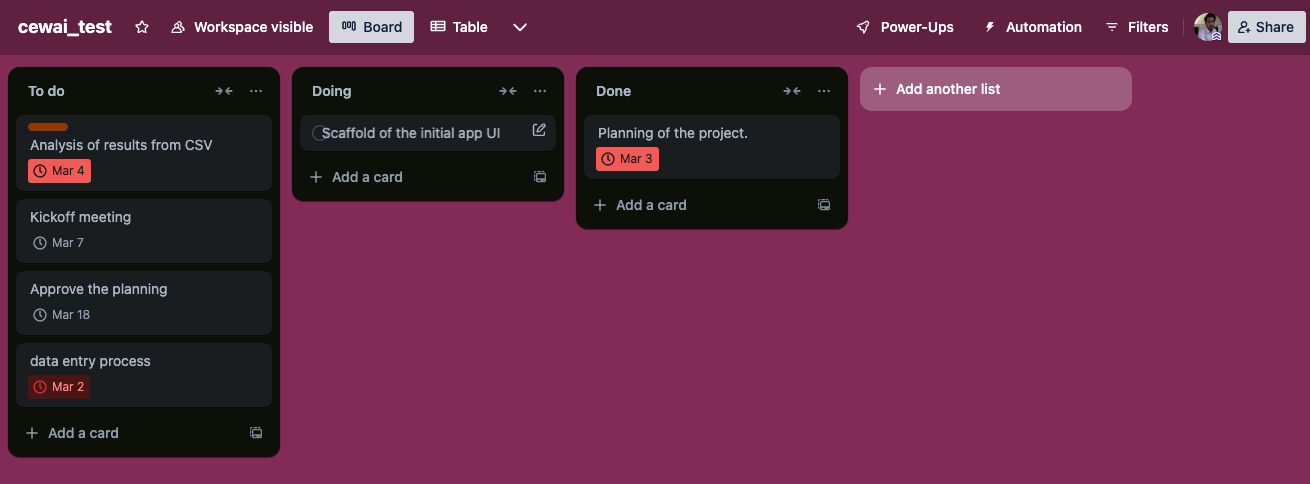

In [13]:
# Display the Trello screenshot
from IPython.display import Image, display

# Load and display the image
trello_image = Image(filename='trello.png')
display(trello_image)

### Creating Agents

In [7]:

data_collection_agent = Agent(
  config=agents_config['data_collection_agent'],
  tools=[BoardDataFetcherTool(), CardDataFetcherTool()],
  llm= ollama_llm
)

analysis_agent = Agent(
  config=agents_config['analysis_agent'],
   llm=ollama_llm
)


In [8]:
# Creating Tasks
data_collection = Task(
  config=tasks_config['data_collection'],
  agent=data_collection_agent
)

data_analysis = Task(
  config=tasks_config['data_analysis'],
  agent=analysis_agent
)

report_generation = Task(
  config=tasks_config['report_generation'],
  agent=analysis_agent,
)

In [9]:
# Creating Crew
crew = Crew(
  agents=[
    data_collection_agent,
    analysis_agent
  ],
  tasks=[
    data_collection,
    data_analysis,
    report_generation
  ],
  verbose=True
)

In [10]:
# Kick off the crew and execute the process
result = crew.kickoff()

# Agent: Data Collection Specialist
## Task: Create an initial understanding of the project, its main features and the team working on it. Use the Trello Data Fetcher tool to gather data from the Trello board.

Getting data from Trello board 
Here is the board data :  [{'id': '67c6a828067238d98405ff78', 'name': 'Analysis of results from CSV', 'idList': '67c6a828d79ba4b87d5bc927', 'due': '2025-03-04T09:42:00.000Z', 'dateLastActivity': '2025-03-04T10:13:06.498Z', 'labels': [{'id': '67c6a827016a2f43f888bed0', 'idBoard': '67c6a827016a2f43f888be8d', 'idOrganization': '67c6a825b8d28b41b2a2e8b4', 'name': '', 'nodeId': 'ari:cloud:trello::label/workspace/67c6a825b8d28b41b2a2e8b4/67c6a827016a2f43f888bed0', 'color': 'orange', 'uses': 1}], 'attachments': [], 'actions': []}, {'id': '67c6a828c1b8984ec19a6227', 'name': 'Kickoff meeting', 'idList': '67c6a828d79ba4b87d5bc927', 'due': '2025-03-07T09:41:00.000Z', 'dateLastActivity': '2025-03-04T09:41:30.966Z', 'labels': [], 'attachments': [], 'actions': 

In [11]:
import pandas as pd

costs = 0.150 * (crew.usage_metrics.prompt_tokens + crew.usage_metrics.completion_tokens) / 1_000_000
print(f"Total costs: ${costs:.4f}")

# Convert UsageMetrics instance to a DataFrame
df_usage_metrics = pd.DataFrame([crew.usage_metrics.dict()])
df_usage_metrics

Total costs: $0.0014


,total_tokens,prompt_tokens,cached_prompt_tokens,completion_tokens,successful_requests
0,9183,7938,0,1245,7


In [12]:
from IPython.display import Markdown

markdown  = result.raw
Markdown(markdown)

Sprint Report
=========================

### Sprint Overview
-------------------

The current sprint began on 2025-03-07T09:41:00.000Z and is expected to conclude on an unspecified date due to the lack of a specified end date for Task "Scaffold of the initial app UI". The team has made progress in various areas, but several issues have emerged that need attention.

### Task Summary
-----------------

| Date | Event Type   | Description                |
|------|--------------|---------------------------|
| 2025-03-04T09:42:00.000Z | Task Creation | Analysis of results from CSV |
| 2025-03-07T09:41:00.000Z | Scheduled     | Kickoff meeting               |
| 2025-03-02T09:42:00.000Z | Scheduled     | Data entry process           |
| 2025-03-03T09:42:00.000Z | Scheduled     | Planning of the project      |
| 2025-03-18T09:41:00.000Z | Scheduled     | Approve the planning         |

### Identified Issues and Blockers
---------------------------------

Several issues have been identified that may impact the team's progress:

*   The data entry process (Task "Data entry process") was scheduled to take place on 2025-03-02T09:42:00.000Z, but its actual start date is unknown due to a lack of information.
*   The kickoff meeting (Task "Kickoff meeting") was scheduled for 2025-03-07T09:41:00.000Z, which may not have occurred yet, given the analysis' timestamp of 2025-03-04T09:42:00.000Z.
*   There is no due date specified for Task "Scaffold of the initial app UI", making it challenging to determine when this task will be completed.

### Progress and Delays
-----------------------

The team has made some progress, but there are concerns about delays:

*   Task "Analysis of results from CSV" was created on 2025-03-04T09:42:00.000Z, indicating that the analysis has been completed.
*   The planning of the project (Task "Planning of the project") was scheduled to take place on 2025-03-03T09:42:00.000Z.

However, there are several potential delays:

*   The data entry process (Task "Data entry process") may be delayed due to a lack of information about its start date.
*   The kickoff meeting (Task "Kickoff meeting") has not taken place yet, which could impact the team's progress.

### Team Performance Overview
-----------------------------

The team's performance is generally good, but there are areas for improvement:

*   The team has made progress in some tasks, such as the analysis of results from CSV.
*   However, there are concerns about delays and lack of information about task start dates, which may impact the team's ability to complete tasks on time.

### Action Items and Recommendations
-------------------------------------

Based on the analysis, the following action items and recommendations have been identified:

*   Clarify the start date for Task "Data entry process" as soon as possible.
*   Schedule the kickoff meeting (Task "Kickoff meeting") as soon as possible to ensure that the team can move forward with the project.
*   Review the task list to identify any other potential delays or blockers and take action to address them.

### Anything Else
------------------

There is no additional information that requires attention at this time. However, it's essential to continue monitoring the project's progress and addressing any issues that arise.